In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import sys
sys.path.append('../')  # Adjust the path as necessary
import dataprocessing
import feature_extractor
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Encode labels, train/test split

filepath = '../datasets/demodag1.csv'
mode = 'HP' #choose mode = 'HP', 'jerk' or 'mean'
categories = ['walking', 'standing', 'laying', 'eating']
#Possible categories: walking, standing, grazing, eating, rubbing, scratch_biting, food_fight, climbing_up,
#brest_feeding, null (other/uncategorized behavior)
#OR
#walking, eating, standing, playing, laying, laying_ruminating, standing_ruminating, unknown, scratching_stand, licking_stand
tagdata = True
features_df = feature_extractor.extract_features(filepath, mode, categories, tagdata) 

X = features_df.drop('label', axis=1)  # Features
y = features_df['label']  # Labels
#print(type(y))

# Encode labels if they're categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# Normalize/Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
#TRAINING
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

In [4]:
#EVALUATION
predictions = rf_classifier.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions, target_names=label_encoder.classes_))


Accuracy: 0.7987804878048781
              precision    recall  f1-score   support

      eating       0.84      0.92      0.88       262
      laying       0.91      1.00      0.95        10
    standing       0.76      0.89      0.82       304
     walking       0.33      0.01      0.02        80

    accuracy                           0.80       656
   macro avg       0.71      0.71      0.67       656
weighted avg       0.75      0.80      0.75       656



All 3 AC component modes similar accuracy. jerk > HP > mean.

n_estimators = 100

test_size = 0.3


rms_az_band3         0.029170
mean_acc_x           0.027593
rms_az_band2         0.025062
rms_ay_band2         0.024339
std_az_band3         0.023319
Q5_x                 0.022416
rms_ax_band3         0.020827
max_acc_x            0.018510
average_intensity    0.017418
max_az_band3         0.017366
dtype: float64


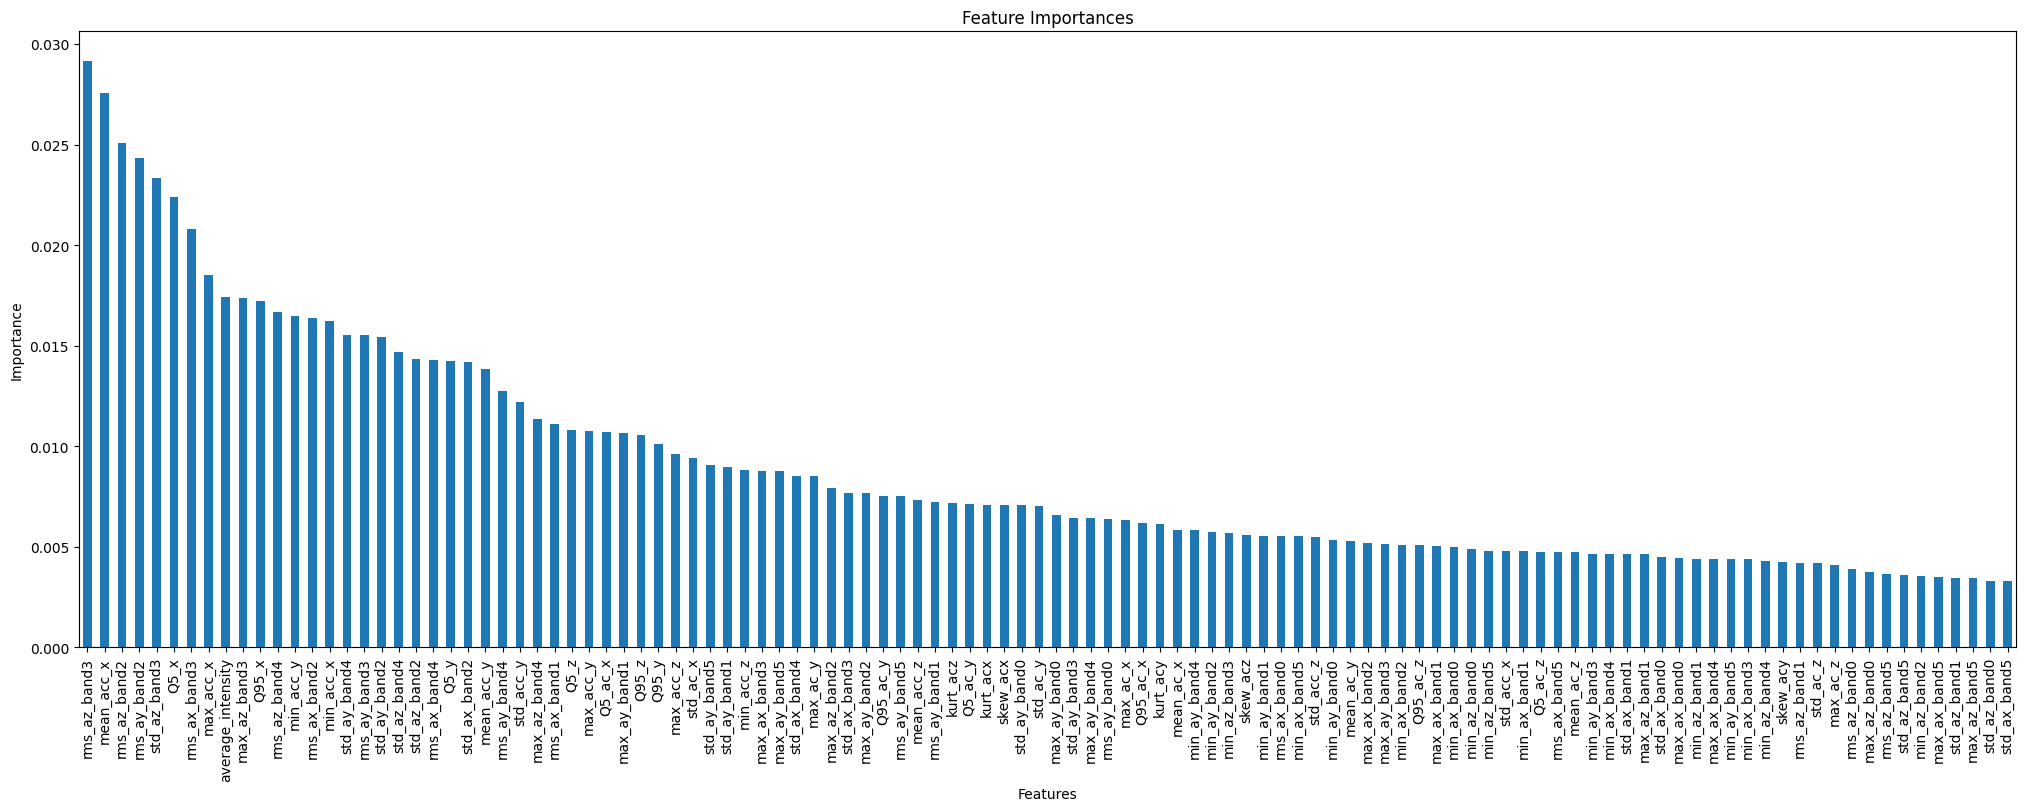

In [5]:
feature_importances = rf_classifier.feature_importances_

feature_names = X_train.columns

importances_series = pd.Series(data=feature_importances, index=feature_names)

importances_series_sorted = importances_series.sort_values(ascending=False)

print(importances_series_sorted.head(10))

plt.figure(figsize=(25,8))
importances_series_sorted.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

Accuracy:  0.8979591836734694
              precision    recall  f1-score   support

      eating       0.74      0.80      0.77       215
     grazing       0.93      0.83      0.88       263
    standing       0.95      0.98      0.96       380
     walking       0.94      0.94      0.94       220

    accuracy                           0.90      1078
   macro avg       0.89      0.89      0.89      1078
weighted avg       0.90      0.90      0.90      1078



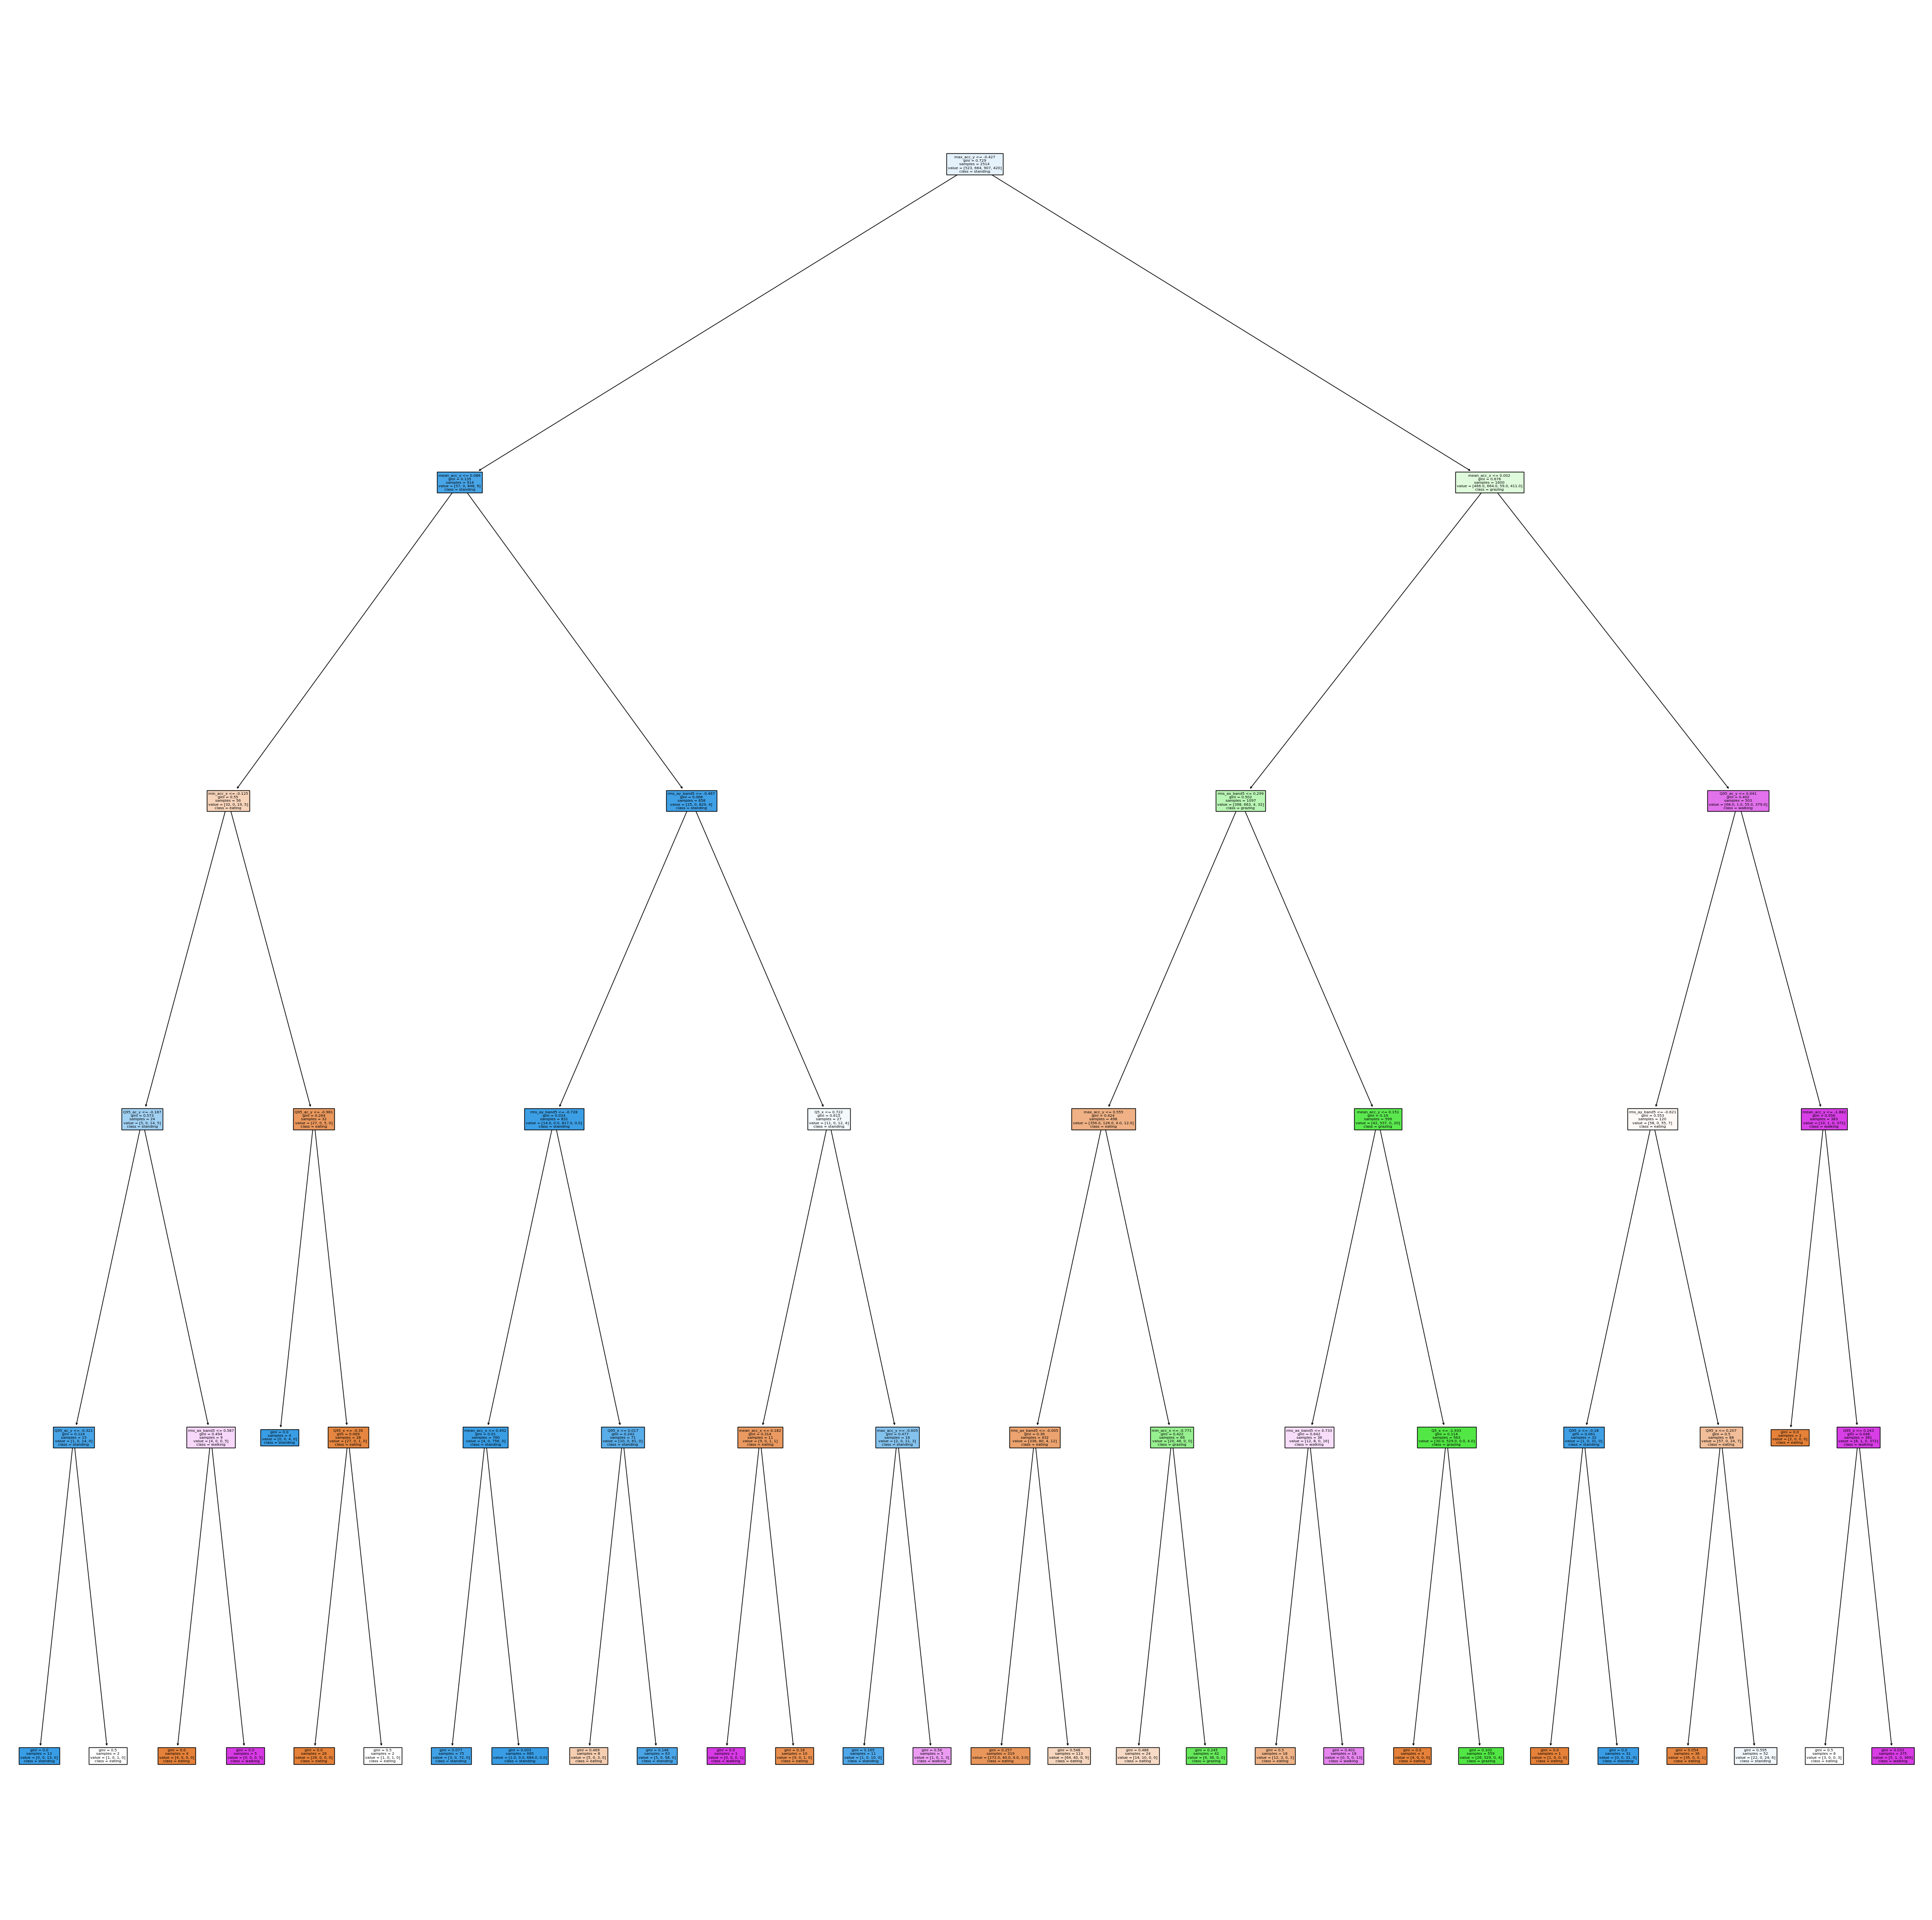

In [7]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

top10 = importances_series_sorted.head(10).index.tolist()

X_train_scaled_df = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X_train_top10 = X_train_scaled_df[top10]
X_test_top10 = X_test_scaled_df[top10]

dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_classifier.fit(X_train_top10, y_train)

pred_dt = dt_classifier.predict(X_test_top10)

print('Accuracy: ', accuracy_score(y_test, pred_dt))
print(classification_report(y_test, pred_dt, target_names=label_encoder.inverse_transform(dt_classifier.classes_)))

plt.figure(figsize=(50,50))
plot_tree(dt_classifier, filled=True, feature_names=top10, class_names=label_encoder.classes_)
plt.show()

In [9]:
n_nodes = dt_classifier.tree_.node_count
children_left = dt_classifier.tree_.children_left
children_right = dt_classifier.tree_.children_right
feature = dt_classifier.tree_.feature
threshold = dt_classifier.tree_.threshold

# Loop through each node to get the feature and threshold
for i in range(n_nodes):
    if children_left[i] != children_right[i]:  # If not a leaf node
        print(f"Node {i} split: {top10[feature[i]]} <= {threshold[i]:.4f}")

Node 0 split: max_acc_y <= -0.4268
Node 1 split: mean_acc_x <= 0.0863
Node 2 split: min_acc_x <= -0.1250
Node 3 split: Q95_ac_y <= -0.1875
Node 4 split: Q95_ac_y <= -0.3215
Node 7 split: rms_ax_band5 <= 0.5867
Node 10 split: Q95_ac_y <= -0.9810
Node 12 split: Q95_x <= -0.3505
Node 15 split: rms_ay_band5 <= -0.4673
Node 16 split: rms_ay_band5 <= -0.7279
Node 17 split: mean_acc_x <= 0.4922
Node 20 split: Q95_x <= 0.0175
Node 23 split: Q5_x <= 0.7221
Node 24 split: mean_acc_x <= 0.1825
Node 27 split: max_acc_y <= -0.6046
Node 30 split: mean_acc_x <= 0.0019
Node 31 split: rms_ax_band5 <= 0.2995
Node 32 split: max_acc_y <= 0.5547
Node 33 split: rms_ax_band5 <= -0.0048
Node 36 split: min_acc_x <= -0.7713
Node 39 split: mean_acc_y <= 0.1506
Node 40 split: rms_ax_band5 <= 0.7335
Node 43 split: Q5_x <= -1.9328
Node 46 split: Q95_ac_y <= 0.0414
Node 47 split: rms_ay_band5 <= -0.6215
Node 48 split: Q95_x <= -0.1803
Node 51 split: Q95_x <= 0.2067
Node 54 split: mean_acc_y <= -1.8819
Node 56 split: